# Audio Predictor Evaluation
This notebook helps to see how audio predictor synthesize voice using existing phonemes

In [1]:
# Base
import itertools
from glob import glob
from tqdm import tqdm
import math
import textgrid
import random
from functools import partial

# ML
import torch
import torch.nn.functional as F
from torch.utils.data import DistributedSampler, DataLoader
from torch.utils.tensorboard import SummaryWriter
from IPython.display import Audio, display
from vocos import Vocos

# Local
from training.misc import plot_specgram, plot_waveform
from training.dataset import create_single_sampler
from supervoice.audio import spectogram, load_mono_audio, resampler
from supervoice.model_audio import AudioPredictor
from supervoice.tokenizer import Tokenizer
from supervoice.tensors import drop_using_mask
from supervoice.config import config
from supervoice.alignment import compute_alignments
from supervoice.minlora import add_lora, apply_to_lora, disable_lora, enable_lora, get_lora_params, merge_lora, name_is_lora, remove_lora, load_multiple_lora, select_lora, LoRAParametrization

In [2]:
device = "cuda:1"

# Vocoder
vocoder = torch.hub.load(repo_or_dir='ex3ndr/supervoice-vocoder', model='bigvsan')
vocoder = vocoder.to(device)
def do_vocoder(src):
    with torch.no_grad():
        return vocoder.generate(src)

flow = torch.hub.load(repo_or_dir='ex3ndr/supervoice-flow', model='flow')

# GPT
phonemizator = torch.hub.load(repo_or_dir='ex3ndr/supervoice-gpt', model='phonemizer')

# Enhance Model
model_enhance = torch.hub.load(repo_or_dir='ex3ndr/supervoice-enhance', model='enhance', vocoder = False)
model_enhance.to(device)
model_enhance.eval()

# Tokenizer
tokenizer = Tokenizer(config)
phoneme_duration = config.audio.hop_size / config.audio.sample_rate

Using cache found in /home/steve/.cache/torch/hub/ex3ndr_supervoice-vocoder_master
Using cache found in /home/steve/.cache/torch/hub/ex3ndr_supervoice-flow_main
Using cache found in /home/steve/.cache/torch/hub/ex3ndr_supervoice-gpt_master
Using cache found in /home/steve/.cache/torch/hub/ex3ndr_supervoice-enhance_main
Using cache found in /home/steve/.cache/torch/hub/ex3ndr_supervoice-flow_main


In [3]:
# sampler = create_single_sampler(["eval"])
# sample_id = 3

sampler = create_single_sampler(["librilight-small"])
sample_id = 3

# sampler = create_single_sampler(["hifi-tts"])
# sample_id = 200070

In [4]:
def extract_tokens(src, style, audio, condition = False):
    aligned_phonemes = compute_alignments(config, src, style, audio.shape[1], not condition)
    phonemes = []
    styles = []
    for t in aligned_phonemes:
        for i in range(t[1]):
            phonemes.append(t[0])
            styles.append(0)
    tokens = tokenizer(phonemes)
    return tokens, phonemes, torch.tensor(styles)

def audio_denormalize(src):
    return (src * config.audio.norm_std) + config.audio.norm_mean

def audio_normalize(src):
    return (src - config.audio.norm_mean) / config.audio.norm_std

def do_spectogram(src):
    return spectogram(src, config.audio.n_fft, config.audio.n_mels, config.audio.hop_size, config.audio.win_size, config.audio.mel_norm, config.audio.mel_scale, config.audio.sample_rate)

def empty_tokens(size):
    return torch.zeros((size)).long().to(device)

def empty_mask(size):
    return torch.ones((size)).bool().to(device)

def do_sample(id):
    (spec, style, tg) = sampler(id)
    spec = spec.T
    tokens, _, _ = extract_tokens(tg, style, spec)
    spec = spec[:, :len(tokens)]
    spec = spec.to(device)
    tokens = tokens.to(device)
    return (spec, tokens)

def do_condition(path):
    waveform = load_mono_audio(path, config.audio.sample_rate)
    waveform = waveform / waveform.abs().max()
    print(waveform.max(), waveform.min())
    spec = do_spectogram(waveform)
    return spec, waveform

### Load Model

In [5]:
model = AudioPredictor(flow, config)
lora_config = {
    torch.nn.Linear: {
        "weight": partial(LoRAParametrization.from_linear, rank=64),
    }
}
add_lora(model.flow, lora_config)
model = model.to(device)
checkpoint = torch.load(f'./output/lora-02.pt', map_location="cpu")
model.load_state_dict(checkpoint['model'])
model.eval()
print("Predictor at ", checkpoint['step'])

Predictor at  150000


In [6]:
def do_inference(*, tokens, audio = None, mask = None, condition = None, alpha = 0.7, steps = 16, enhance = False):
    with torch.no_grad():
        seq_len = len(tokens)
        seq_offset = 0
        s_tokens = tokens.cpu()

        # Process audio
        if audio is None:
            s_audio = torch.zeros((len(tokens), config.audio.n_mels))
        else:
            s_audio = audio_normalize(audio.transpose(1,0))

        # Conditioning spec
        if condition is not None:
            normalized_condition = audio_normalize(condition.transpose(1,0))
            seq_len += condition.shape[1]
            seq_offset += condition.shape[1]
            s_audio = torch.cat([ normalized_condition, s_audio ])
            s_tokens = torch.cat([ torch.zeros(condition.shape[1]).long(), s_tokens])

        # Mask
        if mask is None:
            s_mask = torch.ones((seq_len)).bool()
        else:
            s_mask = torch.zeros((seq_len)).bool()
            s_mask[mask[0] + seq_offset: mask[1] + seq_offset] = True
        s_mask[0:seq_offset] = False

        # Apply mask
        s_audio = drop_using_mask(s_audio, 0, s_mask)
        s_tokens = drop_using_mask(s_tokens, 0, ~s_mask)

        # Move to device
        s_audio = s_audio.to(device)
        s_mask = s_mask.to(device)
        s_tokens = s_tokens.to(device)

        # Inference
        sample, trajectory = model.sample(
            tokens = s_tokens, 
            audio = s_audio, 
            mask = s_mask, 
            steps = steps, 
            alpha = alpha
        )

        # Post-process
        output_spec = audio_denormalize(sample).transpose(1,0)

        # Enhance
        if enhance:
            output_spec = model_enhance.enhance(spec = output_spec, vocoder = False)            

        # Vocoder
        output_audio = do_vocoder(output_spec.unsqueeze(0)).squeeze(0)

        return output_spec.cpu(), output_audio.cpu()

### Load audio with phonemes
This loads sample audio that we would be able to use to compare with synthesized one

Source Audio


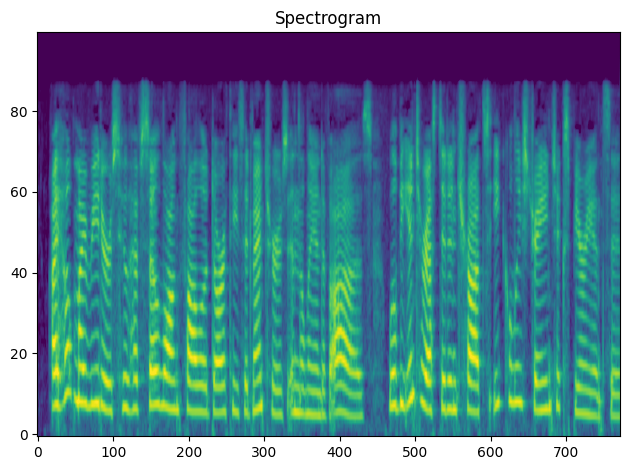

In [7]:
(spec, tokens) = do_sample(sample_id)

print("Source Audio")
display(Audio(data=do_vocoder(spec).cpu(), rate=config.audio.sample_rate))
plot_specgram(spec.cpu())

# Synthesize voice from phonemes
This synthesizes random voice from existing phonemes (taken from another file)

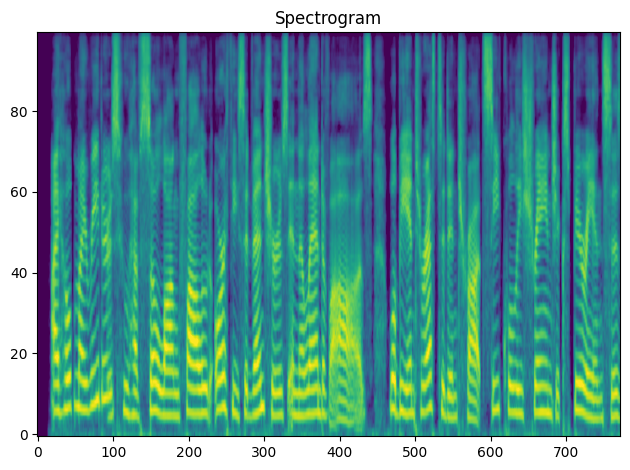

In [8]:
out_spec, out_wav = do_inference(tokens = tokens, enhance = True)
display(Audio(data=out_wav, rate=config.audio.sample_rate))
plot_specgram(out_spec)

In [9]:
out_wav_2 = resampler(config.audio.sample_rate, 16000)(out_wav)
out_wav_2 = resampler(16000, config.audio.sample_rate)(out_wav_2)
display(Audio(data=out_wav_2, rate=config.audio.sample_rate))

### Restore segment
Cut part of the audio and re-generate segment

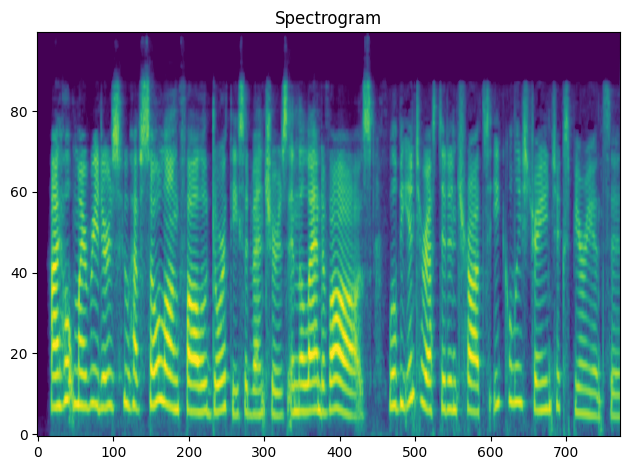

In [10]:
out_spec, out_wav = do_inference(tokens = tokens, audio = spec.cpu(), mask = (math.floor(len(tokens) * 0), math.floor(len(tokens) * 0.6)))
display(Audio(data=out_wav, rate=config.audio.sample_rate))
plot_specgram(out_spec)

### Conditioned TTS

tensor(1.) tensor(-0.5542)


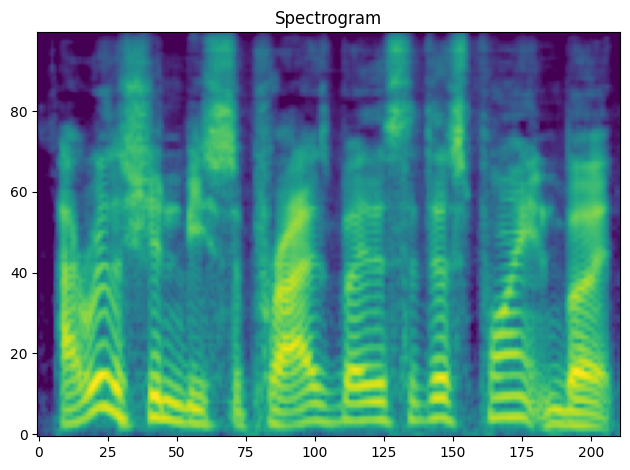

In [13]:
# Load condition
# cond_spec, cond_wav = do_condition("./eval/ltt.m4a")
cond_spec, cond_wav = do_condition("./eval/mkbhd.m4a")
# cond_spec, cond_wav = do_condition("./eval/11.wav")
# cond_spec, cond_wav = do_condition("./eval/10.wav")
# cond_spec, cond_wav = do_condition("./eval/12.wav")
# cond_spec, cond_wav = do_condition("./eval/9.wav")
# cond_spec, cond_wav = do_condition("./eval/ru_0.mp3")
# cond_spec, cond_wav = do_condition("./eval/ru_0.mp3")
# cond_spec, cond_wav = do_condition("./eval/chineese_0.wav")

# Enhance condition
cond_spec = model_enhance.enhance(spec = cond_spec.to(device))
cond_wav = do_vocoder(cond_spec.to(device).unsqueeze(0)).squeeze(0).to(device)
# cond_spec = do_spectogram(cond_wav * 0.98).squeeze(0)
# cond_wav = resampler(config.audio.sample_rate, 16000)(cond_wav)
# cond_wav = resampler(16000, config.audio.sample_rate)(cond_wav)
# cond_spec = do_spectogram(cond_wav)

# Play and Show
display(Audio(data=cond_wav.cpu(), rate=config.audio.sample_rate))
plot_specgram(cond_spec.cpu())

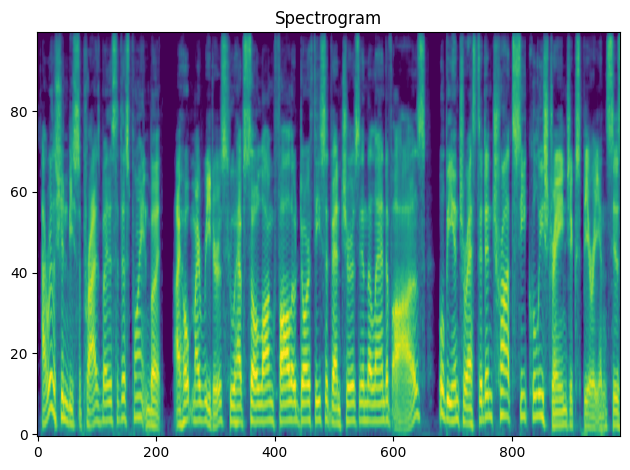

In [14]:
out_spec, out_wav = do_inference(tokens = tokens, condition = cond_spec.cpu(), steps = 32)
display(Audio(data=out_wav, rate=config.audio.sample_rate))
plot_specgram(out_spec)